In [ ]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:85% !important; }</style>"))

In [1]:
import pandas as pd
import numpy as np
import string
from pathlib import Path
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from spellchecker import SpellChecker
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
import tldextract
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import warnings
warnings.filterwarnings("ignore")

PATH = Path('C:/Users/anjana1.yadav/Desktop/dream_book/anjana/Hackerearth_ZS_Associates')
DATA = Path(PATH/'dataset')

In [13]:
def missing_percent(train):
    # Calculate percentage of missing keywords
    for c in train.columns.values:
        bool_series_keyword = pd.isnull(train[c]) 
        #print('{}% of {} are missing from Total Number of Records\n'.format((len(train[bool_series_keyword])/len(train.index))*100, c))
        print('{}% of {} are missing from Total Number of Records\n'.format(len(train[bool_series_keyword]), len(train.index) - len(train[bool_series_keyword]) ))
    
    print("train patient tag counts : ", train.Patient_Tag.value_counts())
    return()


def decontracted(phrase):
    '''
    words in short format needs to be corrected. eg: won't = will not.
    If not done then after preprocessing singular words like "t" will
    remain and give no meaning.
    '''
    
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def nltk_tag_to_wordnet_tag(nltk_tag):
    '''
    The pos-tag format given by the nltk tag does not match the pos-tag 
    format of wordnet. So we need to change the formats. 
    '''
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_sentence(sentence):
    
    '''
    The lemmatizer works better when the pos-tag is also given.
    Lemmatize sentence calculates the pos tag of each word and then
    lemmatizes it.
    '''
    
    lemmatizer = WordNetLemmatizer()
    
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return (" ".join(lemmatized_sentence))


def remove_emoji(text):
    
    '''
    Remove the emojis that might be present in the twitter texts
    '''
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def preprocess(sent):
    
    '''
    Preprocess each sentence by following steps:
    Decontraction -> Punctuation removal -> 
    Stopword removal -> Lemmatization
    '''
    
    #de contract the sentence eg. : don't = do not
    decont_sent = decontracted(remove_emoji(sent))
    word_tokens = word_tokenize(decont_sent)
    
    #remove punctuations
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in word_tokens]
    
    #remove stopwords
    stop_words = stopwords.words('english')
    list_to_remove = ['no', 'not']
    stop_words = set(stop_words).difference(set(list_to_remove))
    
    filtered_sentence = [w.lower() for w in stripped if (not w in stop_words and w.isalpha() and len(w)>2)]
    
    #lemmatization
    lemma = lemmatize_sentence(' '.join(filtered_sentence))

    return(lemma)

def edit_link(sent):
    punct = list(string.punctuation)
    new_sent = ''
    for s in sent:
        if s in punct:
            new_sent+=' '
        else:
            new_sent+=s
            
    tokens = new_sent.split(" ")
    
    stop_words = stopwords.words('english')
    stop_words.extend(['http','co','com','uk','www','net','html','php','cpp','post','forums','boards','threads','thread','forum','feed','utm','org','page','topic','index','pg','htm','qid','id','default','aspx',''])
    list_to_remove = ['no', 'not']
    
    stop_words = set(stop_words).difference(set(list_to_remove))
    
    filtered_sentence = [w for w in tokens if (not w in stop_words and w.isalpha() and len(w)>3)]
    
    return(' '.join(filtered_sentence))


def parameter_tuning(X_train, y_train):
    #defining the expected hyperparameters
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(200, 700, num = 11)]
    max_depth.append(None)
    min_samples_split = [10, 20, 50, 80]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]

    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    print("The set of hyperparameters we are passing to rfc model to tune are:\n", random_grid)

    #Defining the Random Forest Classifier and Randomised search
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1).fit(X_train, y_train)

    print("Optimal Parameters predicted by Randomised Search are: \n", rf_random.best_params_)
    return(rf_random)

def get_domain(url):
    domain = tldextract.extract(url).domain
    return(domain)


In [42]:
# def get_text_features(df): #df=train

#     df.Title = df.Title.fillna(' ')
#     df_features = df[['TRANS_CONV_TEXT', 'Title']]
#     df_features['Domain'] = df.Link.apply(get_domain)
#     df_features.TRANS_CONV_TEXT = df_features.TRANS_CONV_TEXT.progress_apply(preprocess)
#     df_features.Title = df_features.Title.progress_apply(preprocess)
#     df_features['Link'] = df.Link.apply(edit_link)
# #     df_features['Link'] = [' '.join(df_features.Link[i] + [df_features.Title[i]]) for i in df_features.index]
    
#     return(df_features)


# def get_tfidf_vectorizer(df): #df=df_features
    
#     corpus_text = df.TRANS_CONV_TEXT.values
#     corpus_link = df.Link.values

#     vectorizer_text = TfidfVectorizer(max_df=0.05, max_features=500)
#     X_text = vectorizer_text.fit_transform(corpus_text)

#     vectorizer_link = TfidfVectorizer(max_df=0.1, max_features=70)
#     X_link = vectorizer_link.fit_transform(corpus_link)
    
#     return(X_text, X_link, vectorizer_text, vectorizer_link)

def get_text_features(df): #df=train
    
    df.Title = df.Title.fillna(' ')
    df2 = df[['TRANS_CONV_TEXT', 'Title']]
    df2['Domain'] = df.Link.apply(get_domain)
    df2.TRANS_CONV_TEXT = df2.TRANS_CONV_TEXT.progress_apply(preprocess)
    df2.Title = df2.Title.progress_apply(preprocess)
    df2['Link'] = df.Link.apply(edit_link)
    
    return(df2)


def get_tfidf_vectorizer(df2): #df=df_features:
    
    corpus_text = df2.TRANS_CONV_TEXT.values
    corpus_link = df2.Link.values
    corpus_domain = df2.Domain.values
    corpus_title = df2.Title.values

    vectorizer_text = TfidfVectorizer(max_df=0.05, max_features=500)
    X_text = vectorizer_text.fit_transform(corpus_text)

    vectorizer_link = TfidfVectorizer(max_df=0.05, max_features=500)
    X_link = vectorizer_link.fit_transform(corpus_link)

    vectorizer_domain = TfidfVectorizer(max_df=0.05, max_features=500)
    X_domain = vectorizer_domain.fit_transform(corpus_domain)

    vectorizer_title = TfidfVectorizer(max_df=0.1, max_features=70)
    X_title = vectorizer_title.fit_transform(corpus_title)

    return(X_text, X_link, X_domain, X_title, vectorizer_text, vectorizer_link, vectorizer_domain, vectorizer_title)


def get_label_encode(df1, df2): #df1=train, df2=df_features
    
    df_sub = df1[['Source']]
    df_sub.Source = df_sub[['Source']].applymap(str.lower)
    
    label_encoder_src = LabelEncoder()
    df_sub['Source'] = label_encoder_src.fit_transform(df_sub.Source).astype('int')

    df_sub['word_count'] = df2['TRANS_CONV_TEXT'].apply(lambda x: len(str(x).split(' ')))
    df_sub['len_stopwords'] = df1.TRANS_CONV_TEXT.apply(lambda x: len(str(x).split(' ')))
    df_sub.len_stopwords = df_sub.len_stopwords - df_sub.word_count
    
    return(df_sub, label_encoder_src)

def merge_df(df1, df2, df3, df4, df5): #df1=X_text, df2=X_link, df3=X_domain, df4=X_title, df5=df_sub
    
    df_text = pd.DataFrame(data=csr_matrix(df1).todense())
    df_link = pd.DataFrame(data=csr_matrix(df2).todense())
    df_domain = pd.DataFrame(data=csr_matrix(df3).todense())
    df_title = pd.DataFrame(data=csr_matrix(df4).todense())
    
    df_train = pd.DataFrame(np.hstack([df_text, df_link, df_domain, df_title, df_sub]))
    
    return(df_train)


def get_train_transforms(train):
    
    df_features = get_text_features(train)
    X_text, X_link, X_domain, X_title, vectorizer_text, vectorizer_link, vectorizer_domain, vectorizer_title = get_tfidf_vectorizer(df_features)
    df_sub, label_encoder_src = get_label_encode(train, df_features)
    df_final = merge_df(X_text, X_link, X_domain, X_title, df_sub)
    
    text_feat = np.array(['TRANS_CONV_TEXT.'], dtype=np.object) + np.asarray(vectorizer_text.get_feature_names(), dtype=np.object)
    link_feat = np.array(['LINK.'], dtype=np.object) + np.asarray(vectorizer_link.get_feature_names(), dtype=np.object)
    dom_feat =  np.array(['DOMAIN.'], dtype=np.object) + np.asarray(vectorizer_domain.get_feature_names(), dtype=np.object)
    titl_feat = np.array(['TITLE.'], dtype=np.object) + np.asarray(vectorizer_title.get_feature_names(), dtype=np.object)
    sub_feat = ['Source', 'word_count', 'len_stopwords']

    features = np.hstack([text_feat, link_feat, dom_feat, titl_feat, sub_feat])
    
    return(df_final, df_final.values, vectorizer_text, vectorizer_link, vectorizer_domain, vectorizer_title, label_encoder_src, features)


In [4]:
train = pd.read_csv(Path(DATA/'train.csv'), engine='python')
test = pd.read_csv(Path(DATA/'test.csv'), engine='python')
train.drop(['Host', 'Date(ET)','Time(ET)','time(GMT)'], inplace=True, axis=1)
train.dropna(subset=['TRANS_CONV_TEXT'], inplace=True)

In [6]:
missing_percent(train)

0% of 1156 are missing from Total Number of Records

0% of 1156 are missing from Total Number of Records

216% of 940 are missing from Total Number of Records

0% of 1156 are missing from Total Number of Records

0% of 1156 are missing from Total Number of Records

train patient tag counts :  0    916
1    240
Name: Patient_Tag, dtype: int64


()

In [7]:
train.head(5)

,Source,Link,Title,TRANS_CONV_TEXT,Patient_Tag
0,FORUMS,http://cafepharma.com/boards/threads/epstein.5...,Epstein,I don't disagree with you in principle. I'm ju...,0
1,FORUMS,http://www.patient.co.uk/forums/discuss/enlarg...,Enlarged Heart.Thread Enlarged Heart,I am always dizzy I get dizzy standing up so I...,1
2,BLOG,http://abcnewsradioonline.com/entertainment-ne...,Queen Latifah Joins American Heart Association...,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0
3,FORUMS,http://www.cancer-forums.net/viewtopic.php?f=1...,Bulaemia,I am 17 and I have been throwing up for about ...,1
4,FORUMS,http://www.diyaudio.com/forums/lounge/292252-d...,DIY Silver interconnects and RCAs???,Quote: Originally Posted by Boyan Silyavski Wa...,0


In [16]:
df_features = get_text_features(train)

In [43]:
df_train, X, vectorizer_text, vectorizer_link, vectorizer_domain, vectorizer_title, label_encoder_src, features = get_train_transforms(train)

In [19]:
# df = train.copy()
# df2 = df_features.copy()

# corpus_text = df2.TRANS_CONV_TEXT.values
# corpus_link = df2.Link.values
# corpus_domain = df2.Domain.values
# corpus_title = df2.Title.values

# vectorizer_text = TfidfVectorizer(max_df=0.05, max_features=500)
# X_text = vectorizer_text.fit_transform(corpus_text)

# vectorizer_link = TfidfVectorizer(max_df=0.05, max_features=500)
# X_link = vectorizer_link.fit_transform(corpus_link)

# vectorizer_domain = TfidfVectorizer(max_df=0.05, max_features=500)
# X_domain = vectorizer_domain.fit_transform(corpus_domain)

# vectorizer_title = TfidfVectorizer(max_df=0.1, max_features=70)
# X_title = vectorizer_title.fit_transform(corpus_title)

# text_feat = np.array(['TRANS_CONV_TEXT.'], dtype=np.object) + np.asarray(vectorizer_text.get_feature_names(), dtype=np.object)
# link_feat = np.array(['LINK.'], dtype=np.object) + np.asarray(vectorizer_link.get_feature_names(), dtype=np.object)
# dom_feat =  np.array(['DOMAIN.'], dtype=np.object) + np.asarray(vectorizer_domain.get_feature_names(), dtype=np.object)
# titl_feat = np.array(['TITLE.'], dtype=np.object) + np.asarray(vectorizer_title.get_feature_names(), dtype=np.object)
# sub_feat = ['Source', 'word_count', 'len_stopwords']

# features = np.hstack([text_feat, link_feat, dom_feat, titl_feat, sub_feat])
# features

# df_sub = df[['Source']]

# df_sub.Source = df_sub[['Source']].applymap(str.lower)

# label_encoder_src = LabelEncoder()
# df_sub['Source'] = label_encoder_src.fit_transform(df_sub.Source).astype('int')

# df_sub['word_count'] = df2['TRANS_CONV_TEXT'].apply(lambda x: len(str(x).split(' ')))
# df_sub['len_stopwords'] = df.TRANS_CONV_TEXT.apply(lambda x: len(str(x).split(' ')))
# df_sub.len_stopwords = df_sub.len_stopwords - df_sub.word_count

# #df1=X_text, df2=X_link, df3=df_sub

# df_text = pd.DataFrame(data=csr_matrix(X_text).todense())
# df_link = pd.DataFrame(data=csr_matrix(X_link).todense())
# df_domain = pd.DataFrame(data=csr_matrix(X_domain).todense())
# df_title = pd.DataFrame(data=csr_matrix(X_title).todense())

# df_train = pd.DataFrame(np.hstack([df_text, df_link, df_domain, df_title, df_sub]))
# df_train.head()

In [44]:
y = train.Patient_Tag.values

rfc = RandomForestClassifier(n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=700, bootstrap=True)
rfc.fit(X, y)

importance = rfc.feature_importances_

In [67]:
feature_importance_df = pd.DataFrame(data = {'Feature_name':features, 'Importance': importance})
most_important = feature_importance_df.sort_values('Importance', ascending = False).iloc[:70]

# most_important = most_important[most_important.Importance >= 0.006]
indexes_important = list(most_important.index)

In [68]:
len(indexes_important)

70

In [53]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x=most_important.Feature_name, y=most_important.Importance)])
fig.show()

In [69]:
df_train_100 = df_train.loc[:,indexes_important]
y = train.Patient_Tag.values
X = df_train_100.values
rfc = RandomForestClassifier(n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=700, bootstrap=True)
print(cross_val_score(rfc, X, y, cv=3, scoring='f1'))

[0.68493151 0.66666667 0.61333333]


In [ ]:
# X, vectorizer_text, vectorizer_link, label_encoder_src, label_encoder_src = get_train_transforms(train)
# y = train.Patient_Tag.values
#rfc = RandomForestClassifier(n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=700, bootstrap=True).fit(X, y)

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state = 2) 
# X_train_smote, y_train_smote = sm.fit_sample(X, y.ravel())

# rfc = RandomForestClassifier(n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=700, bootstrap=True)
# print(cross_val_score(rfc, X_train_smote, y_train_smote, cv=3, scoring='f1'))

(array([0, 1], dtype=int64), array([234,  55], dtype=int64))
0.24880180794694504


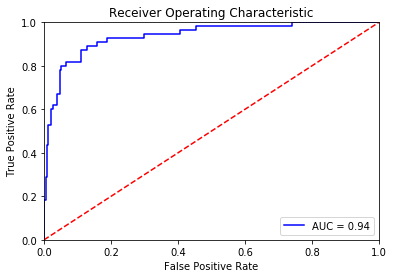

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       234
           1       0.62      0.89      0.73        55

    accuracy                           0.88       289
   macro avg       0.80      0.88      0.83       289
weighted avg       0.90      0.88      0.88       289



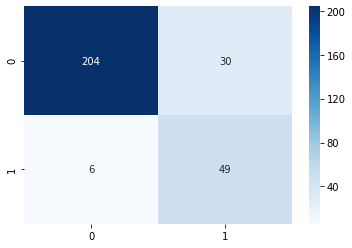

In [70]:
#feature importance 100
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns


X_train, X_test, y_train, y_test = train_test_split(X, y)
print(np.unique(y_test, return_counts=True))

rfc = RandomForestClassifier(n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=700, bootstrap=True).fit(X_train, y_train)


predicted_proba = rfc.predict_proba(X_test)

preds = predicted_proba[:,1]
fpr, tpr, threshold_list = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
threshold = threshold_list[optimal_idx]
print(threshold)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

predicted = (predicted_proba [:,1] >= threshold).astype('int')
accuracy = metrics.classification_report(y_test, predicted)
print(accuracy)
cf_matrix = metrics.confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, fmt='', cmap='Blues', annot=True)

(array([0, 1], dtype=int64), array([218, 240], dtype=int64))
0.4932653633084668


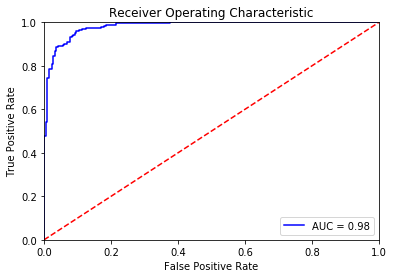

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       218
           1       0.92      0.96      0.94       240

    accuracy                           0.93       458
   macro avg       0.93      0.93      0.93       458
weighted avg       0.93      0.93      0.93       458



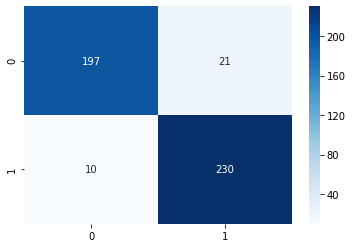

In [74]:
#smote important 50 data
from sklearn.model_selection import train_test_split
from sklearn import metrics

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2) 
X_train_smote, y_train_smote = sm.fit_sample(X, y.ravel())


X_train, X_test, y_train, y_test = train_test_split(X_train_smote, y_train_smote)
print(np.unique(y_test, return_counts=True))

rfc = RandomForestClassifier(n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=700, bootstrap=True).fit(X_train, y_train)

predicted_proba = rfc.predict_proba(X_test)

preds = predicted_proba[:,1]
fpr, tpr, threshold_list = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
threshold = threshold_list[optimal_idx]
print(threshold)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

predicted = (predicted_proba [:,1] >= threshold).astype('int')
accuracy = metrics.classification_report(y_test, predicted)
print(accuracy)
cf_matrix = metrics.confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, fmt='', cmap='Blues', annot=True)

In [ ]:
def get_test_tfidf(df, v_text = vectorizer_text, v_link = vectorizer_link):  #df = df_test_features
    
    X_text = v_text.transform(df.TRANS_CONV_TEXT.values)
    X_link = v_link.transform(df.Title.values)

    return(X_text, X_link)

def encoding_src(sent, label_encoder = label_encoder_src):
    try:
        return label_encoder.transform(sent).astype('int')
    except:
        return 0
    
def encoding_link(sent, label_encoder = label_encoder_Link):
    try:
        return label_encoder.transform(sent).astype('int')
    except:
        return 0

def get_test_encoding(df1, df2): #df1 = test, df2 = df_test_features
    
    df_sub = df1[['Source', 'Link']]
    df_sub.Link = df_sub.Link.apply(get_domain)
    df_sub.Source = df_sub[['Source']].applymap(str.lower)
    df_sub.Source = df_sub.Source.apply(encoding_src)
    df_sub.Link = df_sub.Link.apply(encoding_link)

    df_sub['word_count'] = df2['TRANS_CONV_TEXT'].apply(lambda x: len(str(x).split(' ')))
    return(df_sub)

def get_test_transforms(test):
    
    df_test_features = get_text_features(test)
    X_text, X_link = get_test_tfidf(df_test_features)
    df_sub = get_test_encoding(test, df_test_features)
    df_final = merge_df(X_text, X_link, df_sub)
    
    return(df_final.values)

In [ ]:
train.Patient_Tag.value_counts()

In [ ]:
916/(916+240)

In [ ]:
X_test = get_test_transforms(test, vectorizer_text, vectorizer_link, label_encoder_src, label_encoder_src)
predictions = rfc.predict(X_test)
predictions = np.round(predictions).astype(int).reshape(len(test))

sub=pd.DataFrame({'Index':test['Index'].values.tolist(),'Patient_Tag':predictions})
sub.to_csv(PATH/'submission/submission_features_rfc_improved.csv',index=False)

In [ ]:
# # tsne plotting

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls
# import seaborn as sns
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import matplotlib
# %matplotlib inline

# # Import the 3 dimensionality reduction methods
# from sklearn.manifold import TSNE

# Target = train.Patient_Tag

# vectorizer = TfidfVectorizer(max_df=0.05, max_features=70)
# X = vectorizer.fit_transform(corpus_title)

# tsne = TSNE()
# tsne_results = tsne.fit_transform(X) 

# traceTSNE = go.Scatter(
#     x = tsne_results[:,0],
#     y = tsne_results[:,1],
#     name = 0,
# #     hoveron = Target,
#     mode = 'markers',
# #     text = Target.unique(),
#     showlegend = True,
#     marker = dict(
#         size = 8,
#         color = Target,
#         colorscale ='Jet',
#         showscale = False,
#         line = dict(
#             width = 2,
#             color = 'rgb(255, 255, 255)'
#         ),
#         opacity = 0.8
#     )
# )
# data = [traceTSNE]

# layout = dict(title = 'TSNE for Title',
#               hovermode= 'closest',
#               yaxis = dict(zeroline = False),
#               xaxis = dict(zeroline = False),
#               showlegend= True,

#              )

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='styled-scatter')
# py.plot(fig, filename = 'Title_70.html', auto_open=False)

# # tsne plotting

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls
# import seaborn as sns
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import matplotlib
# %matplotlib inline

# # Import the 3 dimensionality reduction methods
# from sklearn.manifold import TSNE

# Target = train.Patient_Tag

# vectorizer = TfidfVectorizer(max_df=0.05, max_features=70)
# X = vectorizer.fit_transform(corpus_title)

# tsne = TSNE()
# tsne_results = tsne.fit_transform(X) 

# traceTSNE = go.Scatter(
#     x = tsne_results[:,0],
#     y = tsne_results[:,1],
#     name = 0,
# #     hoveron = Target,
#     mode = 'markers',
# #     text = Target.unique(),
#     showlegend = True,
#     marker = dict(
#         size = 8,
#         color = Target,
#         colorscale ='Jet',
#         showscale = False,
#         line = dict(
#             width = 2,
#             color = 'rgb(255, 255, 255)'
#         ),
#         opacity = 0.8
#     )
# )
# data = [traceTSNE]

# layout = dict(title = 'TSNE for Title',
#               hovermode= 'closest',
#               yaxis = dict(zeroline = False),
#               xaxis = dict(zeroline = False),
#               showlegend= True,

#              )

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='styled-scatter')
# py.plot(fig, filename = 'Title_70.html', auto_open=False)

# df_temp = pd.concat([df_sub, train[['Patient_Tag']]],axis=1)
# traceTSNE = go.Scatter(
#     x = df_temp['word_count'].values,
#     y = df_temp['len_stopwords'].values,
#     name = 0,
#     mode = 'markers',
# #     text = Target.unique(),
#     showlegend = True,
#     marker = dict(
#         size = 8,
#         color = Target,
#         colorscale ='Jet',
#         showscale = False,
#         line = dict(
#             width = 2,
#             color = 'rgb(255, 255, 255)'
#         ),
#         opacity = 0.8
#     )
# )
# data = [traceTSNE]

# layout = dict(title = 'TSNE for len_stopwords and word_count',
#               hovermode= 'closest',
#               yaxis = dict(zeroline = False),
#               xaxis = dict(zeroline = False),
#               xaxis_title = 'word_count',
#               yaxis_title = 'len_stopwords',
#               showlegend= True,

#              )

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='styled-scatter')
# py.plot(fig, filename = 'len_count.html', auto_open=False)

# # tsne plotting

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls
# import seaborn as sns
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import matplotlib
# %matplotlib inline

# # Import the 3 dimensionality reduction methods
# from sklearn.manifold import TSNE

# Target = train.Patient_Tag

# vectorizer = TfidfVectorizer(max_df=0.05, max_features=70)
# X = vectorizer.fit_transform(corpus_title)

# tsne = TSNE()
# tsne_results = tsne.fit_transform(X) 

# traceTSNE = go.Scatter(
#     x = tsne_results[:,0],
#     y = tsne_results[:,1],
#     name = 0,
# #     hoveron = Target,
#     mode = 'markers',
# #     text = Target.unique(),
#     showlegend = True,
#     marker = dict(
#         size = 8,
#         color = Target,
#         colorscale ='Jet',
#         showscale = False,
#         line = dict(
#             width = 2,
#             color = 'rgb(255, 255, 255)'
#         ),
#         opacity = 0.8
#     )
# )
# data = [traceTSNE]

# layout = dict(title = 'TSNE for Title',
#               hovermode= 'closest',
#               yaxis = dict(zeroline = False),
#               xaxis = dict(zeroline = False),
#               showlegend= True,

#              )

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='styled-scatter')
# py.plot(fig, filename = 'Title_70.html', auto_open=False)

# df_temp = pd.concat([df_sub, train[['Patient_Tag']]],axis=1)
# traceTSNE = go.Scatter(
#     x = df_temp['word_count'].values,
#     y = df_temp['len_stopwords'].values,
#     name = 0,
#     mode = 'markers',
# #     text = Target.unique(),
#     showlegend = True,
#     marker = dict(
#         size = 8,
#         color = Target,
#         colorscale ='Jet',
#         showscale = False,
#         line = dict(
#             width = 2,
#             color = 'rgb(255, 255, 255)'
#         ),
#         opacity = 0.8
#     )
# )
# data = [traceTSNE]

# layout = dict(title = 'TSNE for len_stopwords and word_count',
#               hovermode= 'closest',
#               yaxis = dict(zeroline = False),
#               xaxis = dict(zeroline = False),
#               xaxis_title = 'word_count',
#               yaxis_title = 'len_stopwords',
#               showlegend= True,

#              )

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='styled-scatter')
# py.plot(fig, filename = 'len_count.html', auto_open=False)



# df_temp = pd.concat([df_sub, train[['Patient_Tag']]],axis=1)
# traceTSNE = go.Scatter(
#     x = df_temp['Source'].values,
#     y = df_temp['Patient_Tag'].values,
#     name = 0,
#     mode = 'markers',
#     text = Target.unique(),
#     showlegend = True,
#     marker = dict(
#         size = 8,
#         color = Target,
#         colorscale ='Jet',
#         showscale = False,
#         line = dict(
#             width = 2,
#             color = 'rgb(255, 255, 255)'
#         ),
#         opacity = 0.8
#     )
# )
# data = [traceTSNE]

# layout = dict(title = 'TSNE for Source',
#               hovermode= 'closest',
#               yaxis = dict(zeroline = False),
#               xaxis = dict(zeroline = False),
#               xaxis_title = 'Source',
#               yaxis_title = 'Patient_Tag',
#               showlegend= True,

#              )

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='styled-scatter')
# py.plot(fig, filename = 'Source.html', auto_open=False)

# df_temp = pd.concat([df_sub, train[['Patient_Tag']]],axis=1)
# traceTSNE = go.Scatter(
#     x = df_temp['Source'].values,
#     y = df_temp['Patient_Tag'].values,
#     name = 0,
#     mode = 'markers',
#     text = Target.unique(),
#     showlegend = True,
#     marker = dict(
#         size = 8,
#         color = Target,
#         colorscale ='Jet',
#         showscale = False,
#         line = dict(
#             width = 2,
#             color = 'rgb(255, 255, 255)'
#         ),
#         opacity = 0.8
#     )
# )
# data = [traceTSNE]

# layout = dict(title = 'TSNE for Source',
#               hovermode= 'closest',
#               yaxis = dict(zeroline = False),
#               xaxis = dict(zeroline = False),
#               xaxis_title = 'Source',
#               yaxis_title = 'Patient_Tag',
#               showlegend= True,

#              )

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='styled-scatter')
# py.plot(fig, filename = 'Source.html', auto_open=False)

# # tsne plotting

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls
# import seaborn as sns
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import matplotlib
# %matplotlib inline

# # Import the 3 dimensionality reduction methods
# from sklearn.manifold import TSNE

# Target = train.Patient_Tag

# vectorizer = TfidfVectorizer(max_df=0.05, max_features=70)
# X = vectorizer.fit_transform(corpus_title)

# tsne = TSNE()
# tsne_results = tsne.fit_transform(X) 

# traceTSNE = go.Scatter(
#     x = tsne_results[:,0],
#     y = tsne_results[:,1],
#     name = 0,
# #     hoveron = Target,
#     mode = 'markers',
# #     text = Target.unique(),
#     showlegend = True,
#     marker = dict(
#         size = 8,
#         color = Target,
#         colorscale ='Jet',
#         showscale = False,
#         line = dict(
#             width = 2,
#             color = 'rgb(255, 255, 255)'
#         ),
#         opacity = 0.8
#     )
# )
# data = [traceTSNE]

# layout = dict(title = 'TSNE for Title',
#               hovermode= 'closest',
#               yaxis = dict(zeroline = False),
#               xaxis = dict(zeroline = False),
#               showlegend= True,

#              )

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='styled-scatter')
# py.plot(fig, filename = 'Title_70.html', auto_open=False)

# df_temp = pd.concat([df_sub, train[['Patient_Tag']]],axis=1)
# traceTSNE = go.Scatter(
#     x = df_temp['word_count'].values,
#     y = df_temp['len_stopwords'].values,
#     name = 0,
#     mode = 'markers',
# #     text = Target.unique(),
#     showlegend = True,
#     marker = dict(
#         size = 8,
#         color = Target,
#         colorscale ='Jet',
#         showscale = False,
#         line = dict(
#             width = 2,
#             color = 'rgb(255, 255, 255)'
#         ),
#         opacity = 0.8
#     )
# )
# data = [traceTSNE]

# layout = dict(title = 'TSNE for len_stopwords and word_count',
#               hovermode= 'closest',
#               yaxis = dict(zeroline = False),
#               xaxis = dict(zeroline = False),
#               xaxis_title = 'word_count',
#               yaxis_title = 'len_stopwords',
#               showlegend= True,

#              )

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='styled-scatter')
# py.plot(fig, filename = 'len_count.html', auto_open=False)



# df_temp = pd.concat([df_sub, train[['Patient_Tag']]],axis=1)
# traceTSNE = go.Scatter(
#     x = df_temp['Source'].values,
#     y = df_temp['Patient_Tag'].values,
#     name = 0,
#     mode = 'markers',
#     text = Target.unique(),
#     showlegend = True,
#     marker = dict(
#         size = 8,
#         color = Target,
#         colorscale ='Jet',
#         showscale = False,
#         line = dict(
#             width = 2,
#             color = 'rgb(255, 255, 255)'
#         ),
#         opacity = 0.8
#     )
# )
# data = [traceTSNE]

# layout = dict(title = 'TSNE for Source',
#               hovermode= 'closest',
#               yaxis = dict(zeroline = False),
#               xaxis = dict(zeroline = False),
#               xaxis_title = 'Source',
#               yaxis_title = 'Patient_Tag',
#               showlegend= True,

#              )

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename='styled-scatter')
# py.plot(fig, filename = 'Source.html', auto_open=False)



# print(len(df_temp[(df_temp.Source==0) & (df_temp.Patient_Tag==0)]))
# print(len(df_temp[(df_temp.Source==0) & (df_temp.Patient_Tag==1)]))
# print()
# print(len(df_temp[(df_temp.Source==1) & (df_temp.Patient_Tag==0)]))
# print(len(df_temp[(df_temp.Source==1) & (df_temp.Patient_Tag==1)]))
# print()
# print(len(df_temp[(df_temp.Source==2) & (df_temp.Patient_Tag==0)]))
# print(len(df_temp[(df_temp.Source==2) & (df_temp.Patient_Tag==1)]))
# print()
# print(len(df_temp[(df_temp.Source==3) & (df_temp.Patient_Tag==0)]))
# print(len(df_temp[(df_temp.Source==3) & (df_temp.Patient_Tag==1)]))